# Notebook Imports

In [76]:
from os import walk
from os.path import join
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [103]:
EXAMPLE_FILE = "SpamData/01_Processing/practice_email.txt"
SPAM_1_PATH = "SpamData/01_Processing/spam_assassin_corpus/spam_1"
SPAM_2_PATH = "SpamData/01_Processing/spam_assassin_corpus/spam_2"
EASY_NONSPAM_1_PATH = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_1"
EASY_NONSPAM_2_PATH = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_2"

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = "SpamData/01_Processing/email-text-data.json"
WORD_ID_FILE = "SpamData/01_Processing/word-by-id.csv"

TRAINING_DATA_FILE = "SpamData/02_Training/train-data.txt"
TEST_DATA_FILE = "SpamData/02_Training/test-data.txt"

WHALE_FILE = "SpamData/01_Processing/wordcloud_resources/whale-icon.png"
SKULL_FILE = "SpamData/01_Processing/wordcloud_resources/skull-icon.png"
THUMBS_UP_FILE = "SpamData/01_Processing/wordcloud_resources/thumbs-up.png"
THUMBS_DOWN_FILE = "SpamData/01_Processing/wordcloud_resources/thumbs-down.png"

BOLD_FONT = "SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf"
LIGHT_FONT = "SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Light.ttf"

# Reading Files

In [3]:
stream = open(EXAMPLE_FILE, encoding="latin-1")
message = stream.read()
stream.close()


print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [4]:
stream = open(EXAMPLE_FILE, encoding="latin-1")

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == "\n":
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [5]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [6]:
for i in generate_squares(5):
    print(i, end=" ->")

0 ->1 ->4 ->9 ->16 ->

## Email body extraction

In [7]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding="latin-1")

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == "\n":
                    is_body = True

            stream.close()
            
            email_body = "\n".join(lines)
            
            yield file_name, email_body

In [8]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({"MESSAGE": email_body, "CATEGORY": classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [9]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.head()

C:\Users\filip\AppData\Local\Temp\ipykernel_40752\2860214245.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [10]:
spam_emails.shape

(1898, 2)

In [11]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.head()

C:\Users\filip\AppData\Local\Temp\ipykernel_40752\3198151448.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))


,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [12]:
ham_emails.shape

(3901, 2)

In [13]:
data = pd.concat([spam_emails, ham_emails])
print("Shape of entire dataframe is", data.shape)
data.head()

Shape of entire dataframe is (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


# Data Cleaning: Checking for Missing Values

In [14]:
# Check if any message bodies are null
data.MESSAGE.isnull().values.any()

False

In [15]:
# Check if any message bodies are empty ("")
(data.MESSAGE.str.len() == 0).any()

True

In [16]:
(data.MESSAGE.str.len() == 0).sum()

3

In [17]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

# Remove System File Entries from Dataframe

In [18]:
data.drop(["cmds"], inplace=True)

In [19]:
data.shape

(5796, 2)

# Add Document IDs to Track emails in Dataset

In [20]:
document_ids = range(0, len(data.index))
data["DOC_ID"] = document_ids

In [21]:
data["FILE_NAME"] = data.index
data.set_index("DOC_ID", inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [22]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


# Save to File using Pandas

In [23]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualized (Pie Charts)

In [24]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [25]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

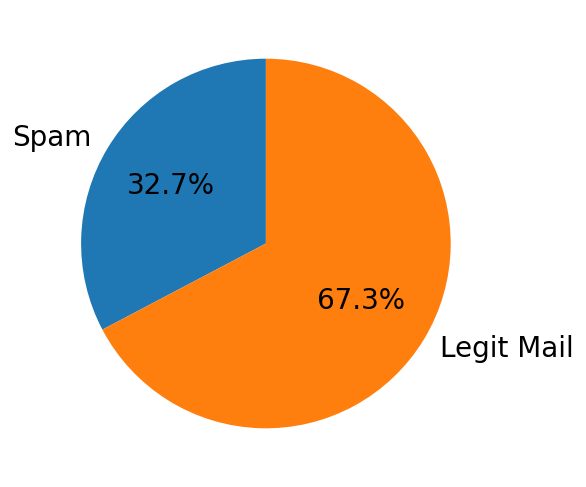

In [26]:
category_names = ["Spam", "Legit Mail"]
sizes = [amount_of_spam, amount_of_ham]

plt.figure(dpi=125)
plt.pie(sizes, labels=category_names, textprops={"fontsize": 16}, startangle=90, autopct="%1.1f%%")
plt.show()

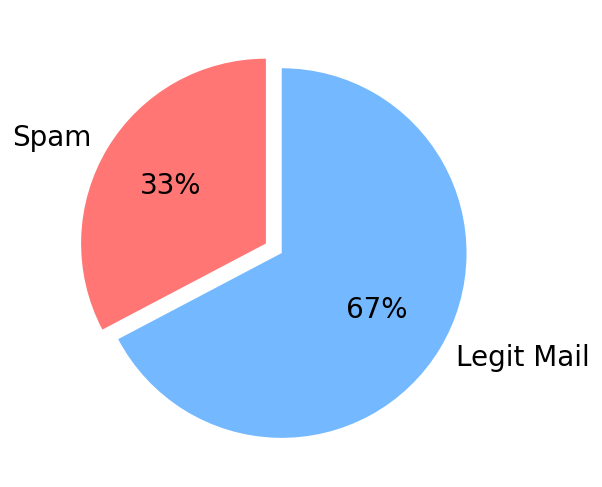

In [27]:
category_names = ["Spam", "Legit Mail"]
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ["#ff7675", "#74b9ff"]

plt.figure(dpi=125)
plt.pie(sizes, labels=category_names, textprops={"fontsize": 16}, startangle=90, 
        autopct="%1.0f%%", colors=custom_colours, explode=[0, 0.1])
plt.show()

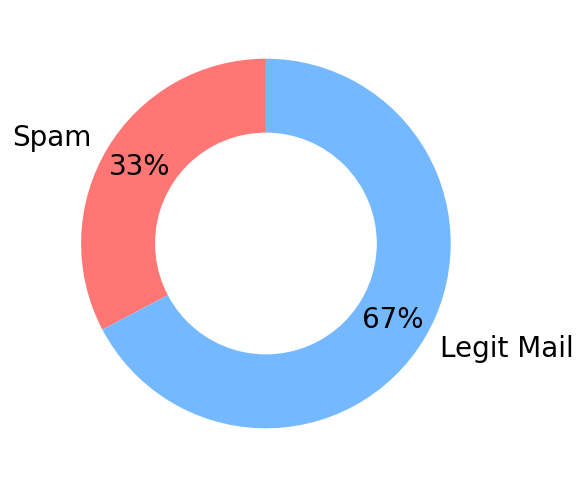

In [28]:
category_names = ["Spam", "Legit Mail"]
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ["#ff7675", "#74b9ff"]

plt.figure(dpi=125)
plt.pie(sizes, labels=category_names, textprops={"fontsize": 16}, startangle=90, 
        autopct="%1.0f%%", colors=custom_colours, pctdistance=0.8)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc="white")
plt.gca().add_artist(centre_circle)

plt.show()

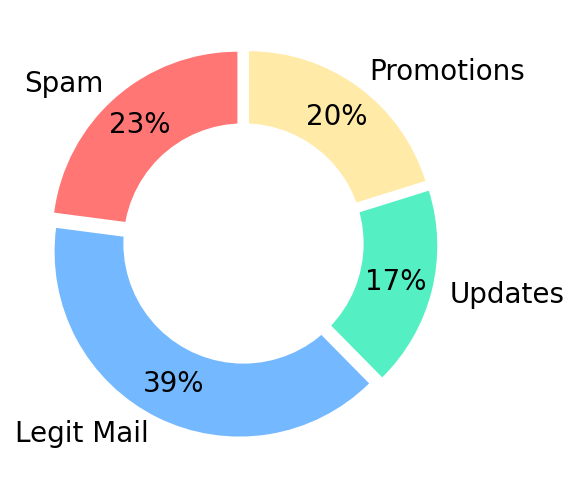

In [29]:
category_names = ["Spam", "Legit Mail", "Updates", "Promotions"]
sizes = [25, 43, 19, 22]
custom_colours = ["#ff7675", "#74b9ff", "#55efc4", "#ffeaa7"]
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(dpi=125)
plt.pie(sizes, labels=category_names, textprops={"fontsize": 16}, startangle=90, 
        autopct="%1.0f%%", colors=custom_colours, pctdistance=0.8, explode=offset)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.65, fc="white")
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

## Text Pre-Processing

### Download the NLTK Resources (Tokenizer & Stopwords)

In [30]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
nltk.download("gutenberg")
nltk.download("shakespeare")

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Tokenising

In [33]:
msg = "All work and no play makes Jack a dull boy."
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stopwords

In [34]:
stop_words = set(stopwords.words("english"))

In [35]:
if 'this' in stop_words: print("Found it!")

Found it!


In [36]:
if 'hello' not in stop_words: print("Nope. Not in here")

Nope. Not in here


In [37]:
msg = "All work and no play makes Jack a dull boy. To be or not to be."
words = word_tokenize(msg.lower())

filtered_words = []
for word in words:
    if word not in stop_words:
        filtered_words.append(word)

filtered_words

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']

## Word Stems and Stemming

(Reducing words to their stem: eg. fishing, fished, fisher, fishlike -> fish)

In [38]:
msg = "All work and no play makes Jack a dull boy. To be or not to be. \
        Nobody expects the Spanish Inquisition!"
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer("english")  # can be used for other languages

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


## Removing Punctuation

In [39]:
msg = "All work and no play makes Jack a dull boy. To be or not to be. \
        Nobody expects the Spanish Inquisition!"
words = word_tokenize(msg.lower())

stemmer = SnowballStemmer("english")  # can be used for other languages

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML tags from Emails

In [40]:
soup = BeautifulSoup(data.at[2, "MESSAGE"], "html.parser")
print(soup.prettify())

1) Fight The Risk of Cancer!

http://www.adclick.ws/p.cfm?o=315&amp;s=pk007



2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days

http://www.adclick.ws/p.cfm?o=249&amp;s=pk007



3) Get the Child Support You Deserve - Free Legal Advice

http://www.adclick.ws/p.cfm?o=245&amp;s=pk002



4) Join the Web's Fastest Growing Singles Community

http://www.adclick.ws/p.cfm?o=259&amp;s=pk007



5) Start Your Private Photo Album Online!

http://www.adclick.ws/p.cfm?o=283&amp;s=pk007



Have a Wonderful Day,

Offer Manager

PrizeMama



























If you wish to leave this list please use the link below.

http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417



In [41]:
soup.get_text()  # Removes html tags

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

## Functions for Email Processing

In [42]:
def clean_message(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words("english"))):
    
    # Converts to lower case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))            
    
    return filtered_words
    

In [43]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [44]:
def clean_message_no_html(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words("english"))):
    soup = BeautifulSoup(message, "html.parser")
    # Converts to lower case and splits up the words
    words = word_tokenize(soup.get_text().lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))            
    
    return filtered_words
    

In [45]:
clean_message_no_html(data.at[2, "MESSAGE"])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

# Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [46]:
data.iat[2, 2]

'00003.2ee33bc6eacdb11f38d052c44819ba6c'

In [47]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,1,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,Help wanted. We are a 14 year old fortune 500...,1,00007.d8521faf753ff9ee989122f6816f87d7
7,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,1,00008.dfd941deb10f5eed78b1594b131c9266
8,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,1,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab
9,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",1,00010.445affef4c70feec58f9198cfbc22997
10,Cellular Phone Accessories All At Below Wholes...,1,00011.61816b9ad167657773a427d890d0468e


In [48]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)

In [49]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]

len(flat_list)

321

In [50]:
%%time

# use apply() on all messages in the dataframe
nested_list = data.MESSAGE.apply(clean_message_no_html)

C:\Users\filip\AppData\Local\Temp\ipykernel_40752\243313903.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, "html.parser")
C:\Users\filip\AppData\Local\Temp\ipykernel_40752\243313903.py:2: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, "html.parser")


CPU times: total: 31.5 s
Wall time: 31.6 s


In [51]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

### Using Logic to Slice Dataframes

In [52]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [53]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

### Subsetting a Series with an Index

In [54]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [55]:
nested_list_ham.shape

(3900,)

In [56]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [57]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]

normal_words = pd.Series(flat_list_ham).value_counts()
spam_words = pd.Series(flat_list_spam).value_counts()

In [58]:
normal_words.shape  # total number of unique words

(20815,)

In [59]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

# Creating a Word Cloud

<function matplotlib.pyplot.show(close=None, block=None)>

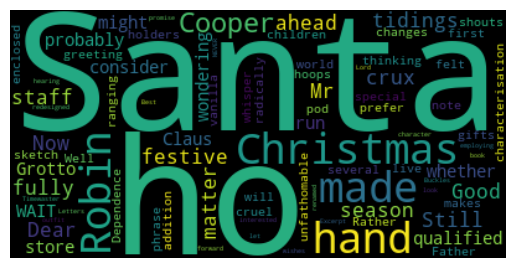

In [60]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show

In [61]:
example_corpus = nltk.corpus.gutenberg.words("melville-moby_dick.txt")
len(example_corpus)

260819

In [62]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

<function matplotlib.pyplot.show(close=None, block=None)>

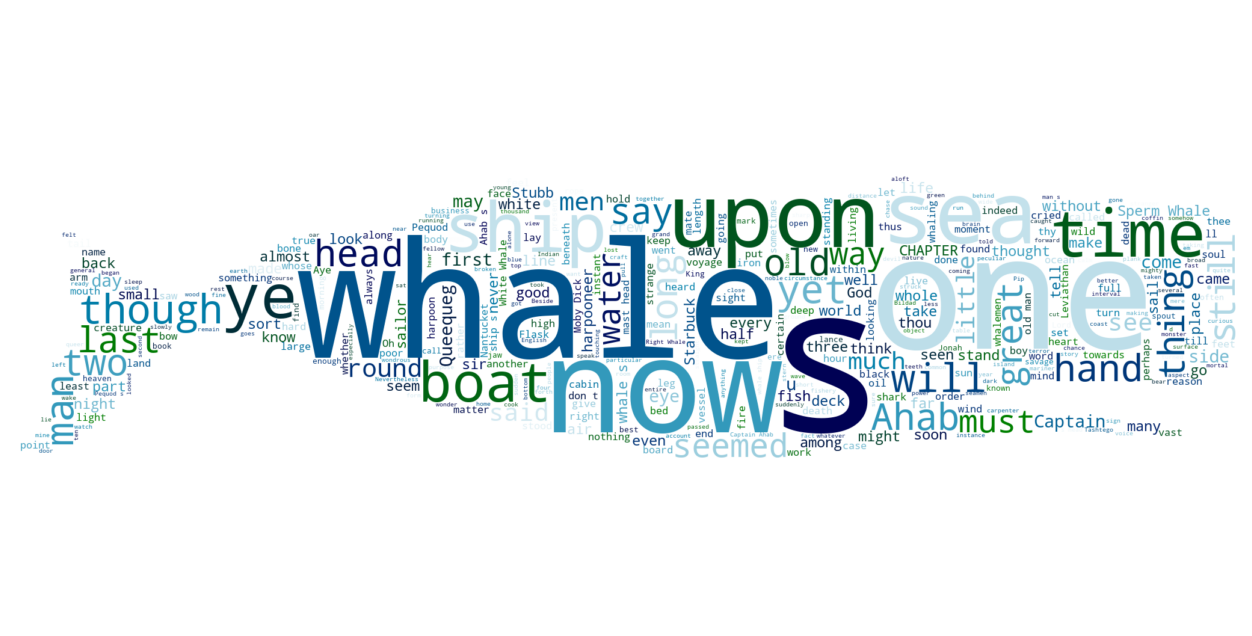

In [63]:
icon =  Image.open(WHALE_FILE)
image_mask = Image.new(mode="RGB", size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask)  # Converts the image object to an array

plt.figure(figsize=[16, 8])
word_cloud = WordCloud(mask=rgb_array, background_color="white",
                      max_words=400, colormap="ocean")

word_cloud.generate(novel_as_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show

## Word cloud for Shakespeare

<function matplotlib.pyplot.show(close=None, block=None)>

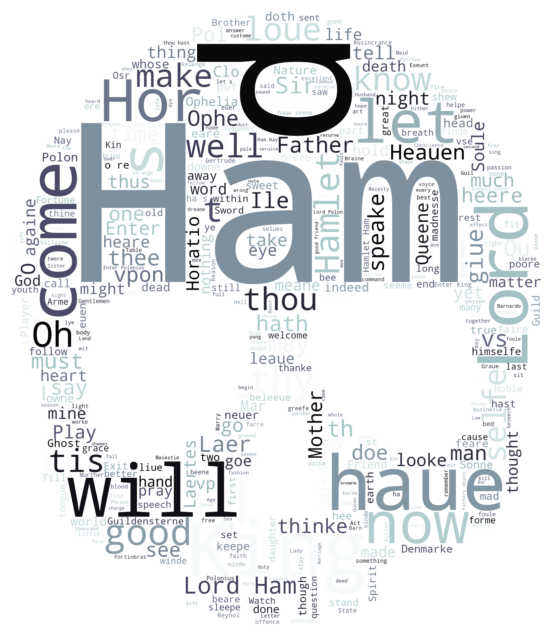

In [64]:
shakespeare_corpus = nltk.corpus.gutenberg.words("shakespeare-hamlet.txt")
word_list = [''.join(word) for word in shakespeare_corpus]
novel_as_string = ' '.join(word_list)

icon =  Image.open(SKULL_FILE)
image_mask = Image.new(mode="RGB", size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask)  # Converts the image object to an array

plt.figure(figsize=[16, 8])
word_cloud = WordCloud(mask=rgb_array, background_color="white",
                      max_words=400, colormap="bone")

word_cloud.generate(novel_as_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show

# Word Cloud of Ham and Spam Messages

<function matplotlib.pyplot.show(close=None, block=None)>

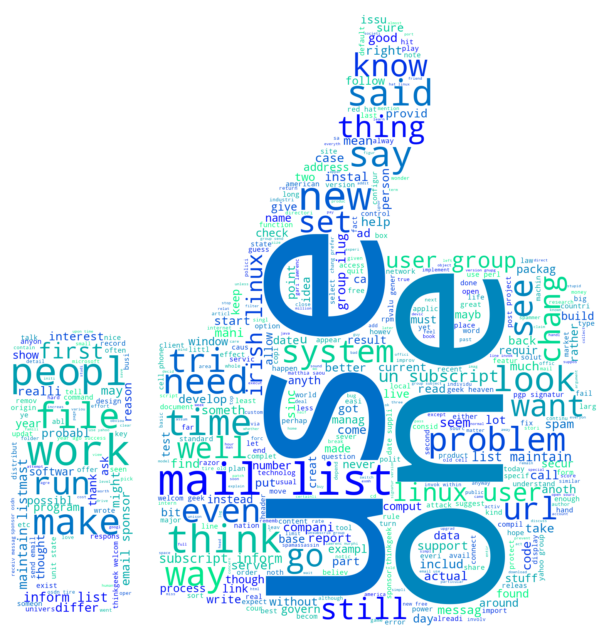

In [65]:
icon =  Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode="RGB", size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask)  # Converts the image object to an array

# Generate the text as a string for the word cloud
ham_str = " ".join(flat_list_ham)

plt.figure(figsize=[16, 8])
word_cloud = WordCloud(mask=rgb_array, background_color="white",
                      max_words=500, colormap="winter")

word_cloud.generate(ham_str)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

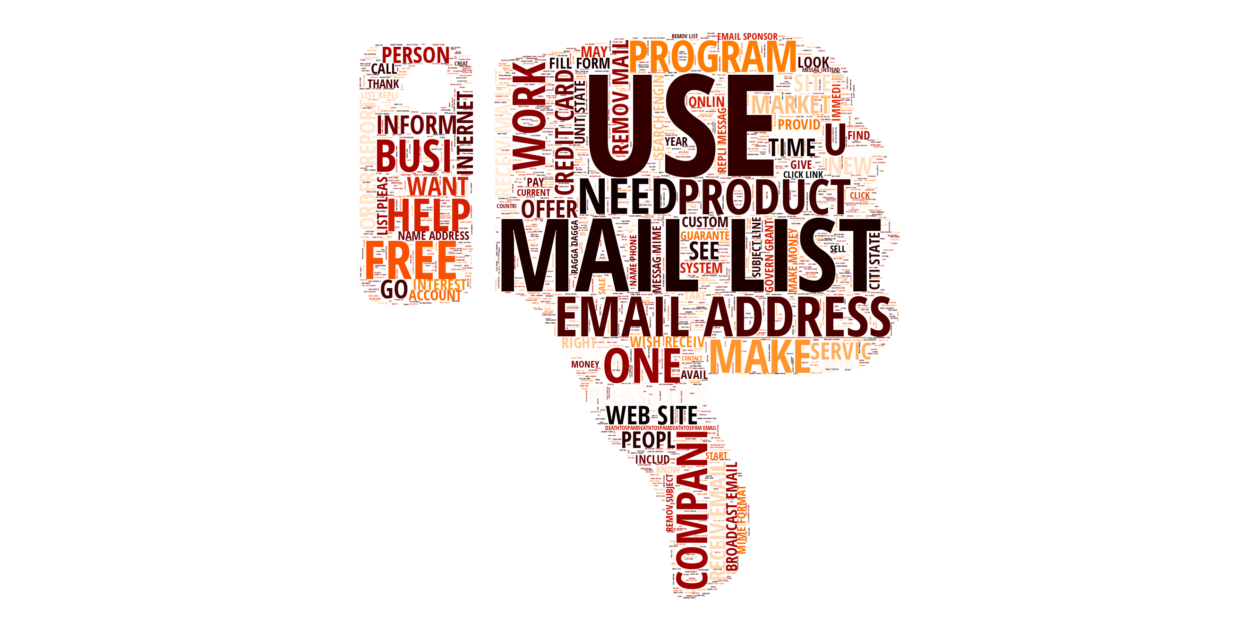

In [66]:
icon =  Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode="RGB", size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask)  # Converts the image object to an array

# Generate the text as a string for the word cloud
spam_str = " ".join(flat_list_spam)

plt.figure(figsize=[16, 8])
word_cloud = WordCloud(mask=rgb_array, background_color="white",
                      max_words=2000, colormap="gist_heat", font_path=BOLD_FONT, max_font_size=300)

word_cloud.generate(spam_str.upper())
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show

# Generate Vocabulary & Dictionary

In [67]:
stemmed_nested_list = data.MESSAGE.apply(clean_message_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\filip\AppData\Local\Temp\ipykernel_40752\243313903.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, "html.parser")
C:\Users\filip\AppData\Local\Temp\ipykernel_40752\243313903.py:2: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, "html.parser")


In [68]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print("Nr of unique words", unique_words.shape[0])
unique_words.head()

Nr of unique words 27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [69]:
frequent_words = unique_words[:VOCAB_SIZE]
frequent_words.head(10)

http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64

## Create Vocabulary DataFrame with a WORD_ID

In [70]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = "WORD_ID"
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [71]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Exercise: Checking if a Word is Part of the Vocabulary

In [72]:
words_to_check = ["machine", "learning", "fun", "learn", "data", "science", "app", "brewery"]
for word in words_to_check:
    if word in set(vocab.VOCAB_WORD):
        print(f"{word}: True")
    else:
        print(f"{word}: False")

machine: False
learning: False
fun: True
learn: True
data: True
science: False
app: True
brewery: False


# Exercise: Find the Email with the Most Number of Words

In [73]:
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print("Nr words in the longest email:", max(clean_email_lengths))
print("Email position in the list (and the data dataframe):", np.argmax(clean_email_lengths))
stemmed_nested_list[np.argmax(clean_email_lengths)]

Nr words in the longest email: 7671
Email position in the list (and the data dataframe): 5775


['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [74]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & a Sparse Matrix

## Creating a DataFrame with one Word per Column

In [75]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


### Splitting the Data into a Training and Testing Dataset

In [77]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size=0.3, random_state=42)

In [79]:
print("Nr of training samples", X_train.shape[0])
print("Fraction of training set", X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples 4057
Fraction of training set 0.6999654934437544


In [80]:
X_train.index.name = X_test.index.name = "DOC_ID"

### Create a Sparsae Matrix for the Training Data

In [82]:
word_index = pd.Index(vocab.VOCAB_WORD)
word_index.get_loc("thu")

393

In [87]:
def make_sparse_matrix(df, indexed_words, labels):
    '''
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    '''
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, "DOC_ID": doc_id, "OCCURENCE": 1, "WORD_ID": word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)
    

In [88]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: total: 5min 22s
Wall time: 5min 31s


### Combine Occurrences with Pandas groupby() Method

In [89]:
train_grouped = sparse_train_df.groupby(["DOC_ID", "WORD_ID", "LABEL"]).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [97]:
vocab.at[3, "VOCAB_WORD"]

'email'

In [98]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [99]:
train_grouped.shape

(258360, 4)

### Save Training Data as .txt File

In [101]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt="%d")

### Sparse Matrix for test data

In [102]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)
test_grouped = sparse_test_df.groupby(["DOC_ID", "WORD_ID", "LABEL"]).sum()
test_grouped = test_grouped.reset_index()
test_grouped.head()

CPU times: total: 2min 24s
Wall time: 2min 27s


,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [104]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt="%d")

# Pre-Processing Subtleties

In [105]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [106]:
len(test_doc_ids)

1724

In [107]:
len(X_test)

1739

In [108]:
set(X_test.index.values) - test_doc_ids

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}

In [129]:
data.MESSAGE[734]

'<html>\n\n<body bgcolor="#7CB5F0">\n\n<a href="http://teens.xxxfreehosting.com/hotteens/index.html"><img border="0" src="http://members.aol.com/tjoyce/mail_01.gif" width="500" height="558" border=0></a><br>\n\n<a href="mailto:flojo@btamail.net.cn"><img border="0" src="http://members.aol.com/tjoyce/mail_02.gif" width="500" height="42" border=0>\n\n</a>\n\n</body>\n\n</html>\n\n4623\n\n\n\n\n'

In [130]:
data.loc[734]

MESSAGE      <html>\n\n<body bgcolor="#7CB5F0">\n\n<a href=...
CATEGORY                                                     1
FILE_NAME               00235.749db1b61dbea4257300c71c9220a4e8
Name: 734, dtype: object

In [132]:
clean_message(data.at[734, "MESSAGE"])

['html', 'bodi', 'http', 'img', 'http', 'br', 'mailto', 'flojo', 'img', 'http']

In [133]:
clean_message_no_html(data.at[734, "MESSAGE"])

[]